In [1]:
""" Import libraries """
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
import torch.utils.data as Data
from numpy import random
import imageio
from utils import *
from sklearn.metrics import r2_score
from models.quantile_networks.toy_quantile_model import *
from models.mixture_density_networks.toy_mdn_model import MDN

random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
os.environ['PYTHONHASHSEED'] = str(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
""" Create toy dataset """
x = torch.unsqueeze(torch.linspace(1, 10, 1000), dim=1)
y = torch.log(x) + 0.2*torch.rand(x.size())                 
x = torch.cat((x,torch.rand(1000,4)), 1)
x, y = Variable(x), Variable(y)

x_test = torch.unsqueeze(torch.linspace(1, 10, 200), dim=1)
y_test = torch.log(x_test) + 0.2*torch.rand(x_test.size())                 
x_test = torch.cat((x_test,torch.rand(200,4)), 1)
x_test, y_test = Variable(x_test), Variable(y_test)


torch_dataset = Data.TensorDataset(x, y)

loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=64, 
    shuffle=True, num_workers=2,)

# Quantile Regression

Test R2 score: 0.9860624770638727


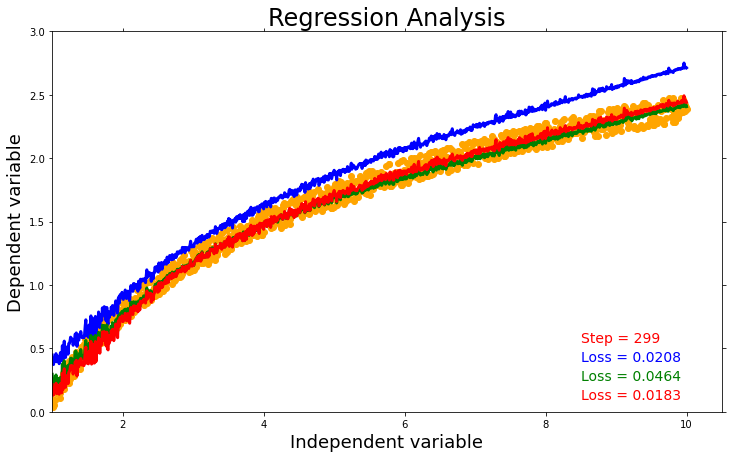

In [3]:
""" Train the network """
my_images = []
fig, ax = plt.subplots(figsize=(12,7))

net_common = Net_common()     # define the network
net_upper = FC(n_feature=64)
net_middle = FC(n_feature=64)
net_lower = FC(n_feature=64)

optimizer_upper = torch.optim.SGD(list(net_common.parameters())+list(net_upper.parameters()), lr=3e-2)

optimizer_middle = torch.optim.SGD(list(net_common.parameters())+list(net_middle.parameters()), lr=3e-2)

optimizer_lower = torch.optim.SGD(list(net_common.parameters())+list(net_lower.parameters()), lr=3e-2)

loss_middle = 'inf'
loss_upper = 'inf'
loss_lower = 'inf'
for t in range(300):
  for step, (batch_x, batch_y) in enumerate(loader): # for each training step  
    b_x = Variable(batch_x)
    b_y = Variable(batch_y) 
    if t%3==0:
      prediction_lower = net_lower(net_common(b_x))     # input x and predict based on x
      loss_lower = tilted_loss(0.2, b_y, prediction_lower)
      optimizer_lower.zero_grad()   # clear gradients for next train
      loss_lower.backward()         # backpropagation, compute gradients
      optimizer_lower.step()        # apply gradients
    elif t%3==1:
      prediction_middle = net_middle(net_common(b_x))     # input x and predict based on x
      loss_middle = tilted_loss(0.5, b_y, prediction_middle)
      optimizer_middle.zero_grad()   # clear gradients for next train
      loss_middle.backward()         # backpropagation, compute gradients
      optimizer_middle.step()        # apply gradients
    else:
      prediction_upper = net_upper(net_common(b_x))     # input x and predict based on x
      loss_upper = tilted_loss(0.8, b_y, prediction_upper)
      optimizer_upper.zero_grad()   # clear gradients for next train
      loss_upper.backward()         # backpropagation, compute gradients
      optimizer_upper.step()        # apply gradients

  prediction_lower = net_lower(net_common(x))
  prediction_middle = net_middle(net_common(x))
  prediction_upper = net_upper(net_common(x)) 
      # plot and show learning process
  plt.cla()
  ax.set_title(f'Regression Analysis', fontsize=24)
  ax.set_xlabel('Independent variable', fontsize=18)
  ax.set_ylabel('Dependent variable', fontsize=18)
  ax.set_xlim(1, 10.5)
  ax.set_ylim(0, 3)
  ax.scatter(x.data.numpy()[:,0], y.data.numpy(), color = "orange")
  ax.plot(x.data.numpy()[:,0], prediction_upper.data.numpy(), 'b-', lw=3)
  ax.plot(x.data.numpy()[:,0], prediction_middle.data.numpy(), 'g-', lw=3)
  ax.plot(x.data.numpy()[:,0], prediction_lower.data.numpy(), 'r-', lw=3)
  ax.text(8.5, 0.55, 'Step = %d' % t, fontdict={'size': 14, 'color':  'red'})
  try:
    ax.text(8.5, 0.4, 'Loss = %.4f' % loss_upper.data.numpy(),
          fontdict={'size': 14, 'color':  'blue'})
  except:
    ax.text(8.5, 0.4, 'Loss = inf',
          fontdict={'size': 14, 'color':  'blue'})
  try:
    ax.text(8.5, 0.25, 'Loss = %.4f' % loss_middle.data.numpy(),
          fontdict={'size': 14, 'color':  'green'})
  except:
    ax.text(8.5, 0.25, 'Loss = inf',
          fontdict={'size': 14, 'color':  'green'})
  try:
    ax.text(8.5, 0.1, 'Loss = %.4f' % loss_lower.data.numpy(),
          fontdict={'size': 14, 'color':  'red'})
  except:
    ax.text(8.5, 0.1, 'Loss = inf',
          fontdict={'size': 14, 'color':  'red'})
  # Used to return the plot as an image array 
  # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
  fig.canvas.draw()       # draw the canvas, cache the renderer
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
  image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

  my_images.append(image)

# save images as a gif
imageio.mimsave(f'../plots/training_quantile_toy_logarithmic.gif', my_images, fps=10)

prediction_middle = net_middle(net_common(x_test))
print(f"Test R2 score: {r2_score(y_test.detach().numpy(), prediction_middle.detach().numpy())}")

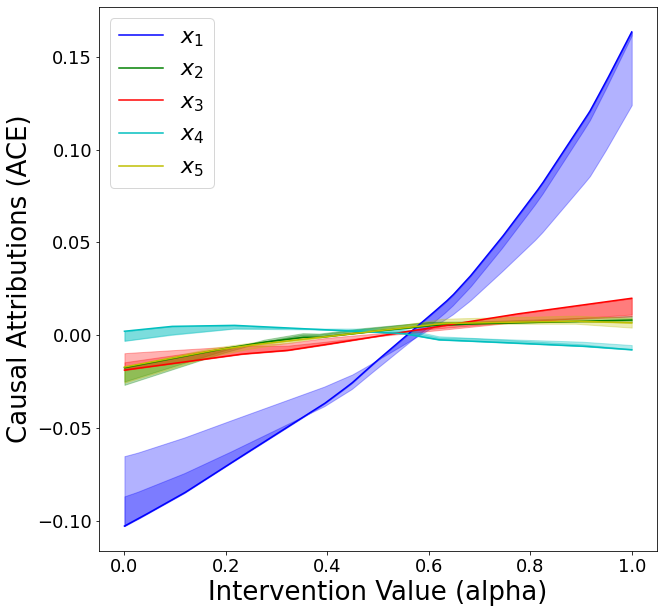

In [4]:
""" Causal Attribution for Quantile Networks"""
from SACE.SACE_quantile import plot_sace_quantile

plot_sace_quantile(x = x, 
                   net_common=net_common,
                   net_upper = net_upper,
                   net_middle = net_middle,
                   net_lower = net_lower,
                   filename = "../plots/quantile_toy_logarithmic_causal_attribution",
                   title = "Causal Attribution for problem: $y = \log({x_1})$")

# Mixture Density Network

Test R2 score: 0.985243187092349


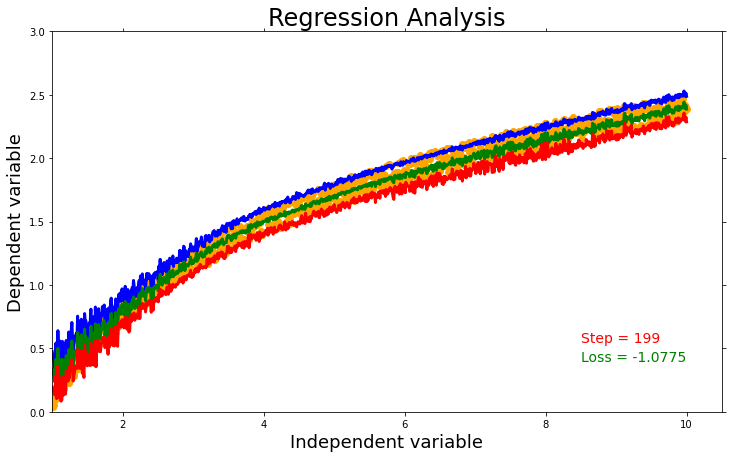

In [5]:
""" Train the network """
my_images = []
fig, ax = plt.subplots(figsize=(12,7))

net = MDN(n_feature=5, n_hidden=32, n_gaussians=1)     # define the network
# print(net)  # net architecture
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3)

for t in range(200):
  for step, (batch_x, batch_y) in enumerate(loader): # for each training step  
    b_x = Variable(batch_x)
    b_y = Variable(batch_y) 

    prediction_pi, prediction_mu, prediction_sigma = net(b_x)     # input x and predict based on x
    loss = mdn_loss_fn(b_y, prediction_mu, prediction_sigma, prediction_pi)
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

  prediction_pi, prediction_mu, prediction_sigma = net(x)
      # plot and show learning process
  plt.cla()
  ax.set_title(f'Regression Analysis', fontsize=24)
  ax.set_xlabel('Independent variable', fontsize=18)
  ax.set_ylabel('Dependent variable', fontsize=18)
  ax.set_xlim(1, 10.5)
  ax.set_ylim(0, 3)
  ax.scatter(x.data.numpy()[:,0], y.data.numpy(), color = "orange")
  ax.plot(x.data.numpy()[:,0], (prediction_mu+prediction_sigma).data.numpy(), 'b-', lw=3)
  ax.plot(x.data.numpy()[:,0], prediction_mu.data.numpy(), 'g-', lw=3)
  ax.plot(x.data.numpy()[:,0], (prediction_mu-prediction_sigma).data.numpy(), 'r-', lw=3)
  ax.text(8.5, 0.55, 'Step = %d' % t, fontdict={'size': 14, 'color':  'red'})
  
  ax.text(8.5, 0.4, 'Loss = %.4f' % loss.data.numpy(),
          fontdict={'size': 14, 'color':  'green'})
  # Used to return the plot as an image array 
  # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
  fig.canvas.draw()       # draw the canvas, cache the renderer
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
  image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

  my_images.append(image)

# save images as a gif
imageio.mimsave(f'../plots/training_mdn_toy_logarithmic.gif', my_images, fps=10)

prediction_pi, prediction_mu, prediction_sigma = net(x_test)
print(f"Test R2 score: {r2_score(y_test.detach().numpy(), prediction_mu.detach().numpy())}")

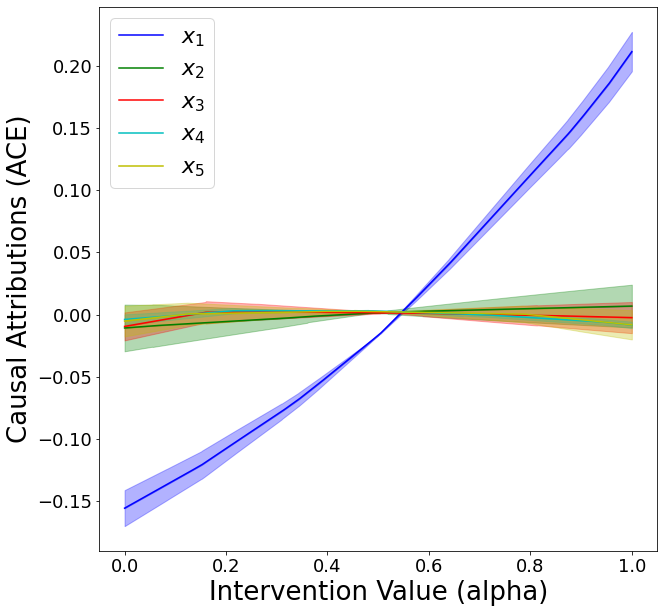

In [6]:
""" Causal Attribution for MDN networks"""
from SACE.SACE_mdn import plot_sace_mdn

plot_sace_mdn(x=x, 
              net=net,
              filename="../plots/mdn_toy_logarithmic_causal_attribution",
              title="Causal Attribution for problem: $y = \log({x_1})$")